In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
import scipy as scp

plt.rcParams['figure.facecolor'] = 'white'

In [46]:
positions=pd.read_excel('Y:\\Istra Repositories\\ch-gr_exports\\Querzug_overview.xlsx')
positions=positions.iloc[:,1:].set_index('name')

In [48]:
def get_df_mask(array:np.ndarray)->pd.DataFrame:
    df=pd.DataFrame(array)
    after=df.copy()
    after[after==0.]=np.nan
    after=np.divide(after,after)
    return(after)
def mask_df(df:np.ndarray,mask:np.ndarray)-> pd.DataFrame:
    after=np.multiply(df,mask)
    after=pd.DataFrame(after)
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
def strip_nans(df):
    after=df.copy()
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)

In [57]:
sample='MC_A_8xiii'
samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
lookup=pd.read_pickle(samplelocation,compression='zip')

In [58]:
def seam_zoom(lookup:pd.DataFrame,vis:str,name:str,positions:pd.DataFrame,width:int):
    """sample=name
    samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
    lookup=pd.read_pickle(samplelocation,compression='zip')"""
    stencil_df=pd.DataFrame(lookup.iloc[10,:][(      'strains',                   'strain_p1')])
    stencil=get_df_mask(stencil_df)
    length_measurement=(mask_df(lookup.iloc[10,:][('coordinates','coordinate_y')],stencil))
    #vis_df_masked=mask_df(lookup.iloc[230,:][vis],stencil)
    #plt.matshow(vis_df_masked)
    #---------------------------------------------
    mean_dict={col:np.nanmean(length_measurement.loc[:,col]) for col in length_measurement.columns}
    measurement_lookup_df=pd.DataFrame(data=mean_dict.values(), index=mean_dict.keys(),columns=['mm'])
    crack_idx=int(positions.loc[name,'crack'])
    seam_idx=int(positions.loc[name,'pos'])
    crack_y_mm=measurement_lookup_df.loc[crack_idx,'mm']
    pos_y_mm=measurement_lookup_df.loc[seam_idx,'mm']
    #display(pos_y_mm)
    left_pos_y_mm=pos_y_mm+(width/2)
    #display(left_pos_y_mm)
    left_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-left_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]
    right_pos_y_mm=pos_y_mm-(width/2)
    right_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-right_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]

    """fix,[ax1,ax2]=plt.subplots(2,1,figsize=(10,5))
    imb=ax1.matshow(vis_df_masked)
    ax1.axvline(seam_idx,color='red')
    ax1.axvline(crack_idx,color='turquoise')
    ax1.axvline(left_pos_y_idx,color='yellow')
    ax1.axvline(right_pos_y_idx,color='yellow')
    imf=ax2.matshow(mask_df(lookup.iloc[232,:][(      'strains',                   'strain_p1')],stencil).loc[:,left_pos_y_idx:right_pos_y_idx])
    offset=left_pos_y_idx
    ax2.axvline(seam_idx-offset,color='red')
    ax2.axvline(crack_idx-offset,color='turquoise')
    ax2.axvline(left_pos_y_idx-offset,color='yellow')
    ax2.axvline(right_pos_y_idx-offset,color='yellow')
    #ax2.set_xticklabels(np.arange(left_pos_y_idx,right_pos_y_idx,10))
    #display(seam_idx,left_pos_y_idx,right_pos_y_idx)"""
    plt.show()
    return(seam_idx,left_pos_y_idx,right_pos_y_idx,crack_idx)
#idxs=seam_zoom(lookup,('strains','strain_p1'),sample,positions)

In [59]:
def refine_stencil(stencil_df_nonans,left,right):
    stencil_df_nonans.loc[:,:left]=np.nan
    stencil_df_nonans.loc[:,right:]=np.nan
    return(stencil_df_nonans)
#plt.matshow(refine_stencil(stencil_df_nonans,100,150))

In [60]:
def create_full_stencil(lookup,positions,name,width):
    stencil_df_origin=pd.DataFrame(lookup.iloc[10,:][(      'strains',                   'strain_p1')])
    stencil_df_nonans=get_df_mask(stencil_df_origin)
    borders=seam_zoom(lookup,('strains','strain_p1'),name,positions,width)
    full_stencil=refine_stencil(stencil_df_nonans,borders[1],borders[2])
    return(full_stencil)
def apply_full_stencil(lookup,stencil):
    vis=pd.DataFrame(lookup)
    vis=vis.multiply(stencil)
    vis=strip_nans(vis)
    return vis
#plt.matshow(create_full_stencil(lookup,positions,sample,25))

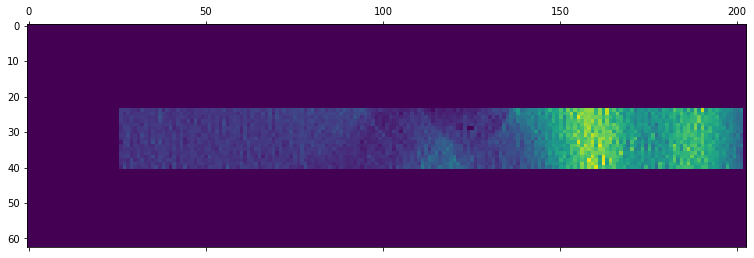

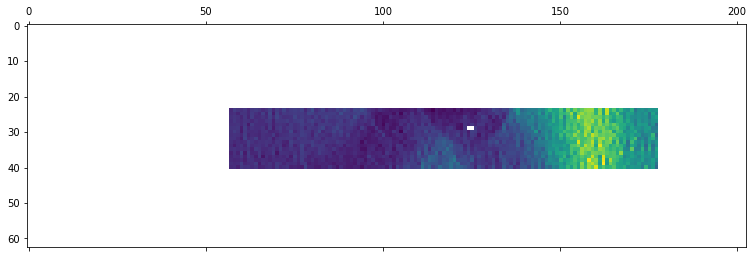

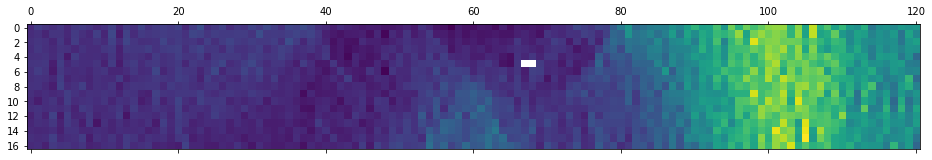

In [62]:
stencil3=create_full_stencil(lookup,positions,sample,75)
stencil2=create_full_stencil(lookup,positions,sample,25)
stencil=create_full_stencil(lookup,positions,sample,50)
vis=pd.DataFrame(lookup.iloc[320,:][(      'strains',                   'strain_p1')])
plt.matshow(vis)
plt.matshow(vis.multiply(stencil))
plt.matshow(apply_full_stencil(vis,stencil))

In [63]:
stenciled_lookup=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil))
display(stenciled_lookup.columns)

MultiIndex([('strains', 'strain_p1'),
            ('strains', 'strain_p2')],
           names=['group', 'dataset'])

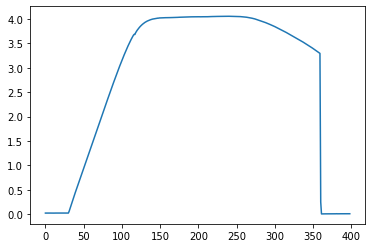

In [64]:
force=[lookup.loc[i,(     'add_data',             'analog_channels')][0][0] for i in lookup.index]
plt.plot(force)

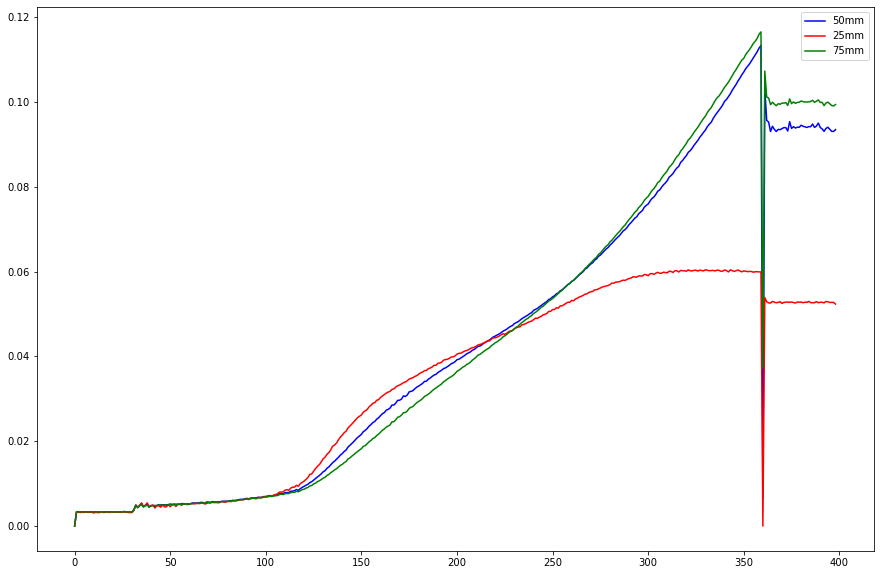

In [69]:
fig,ax=plt.subplots(figsize=(15,10))

meanvector=[]
for i in stenciled_lookup.index:
    meanvector.append(np.mean(np.mean(stenciled_lookup.loc[i,('strains','strain_p1')])))
#display(meanvector)
ax.plot(meanvector,c='blue',label='50mm')

stenciled_lookup_2=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil2))
meanvector=[]
for i in stenciled_lookup_2.index:
    meanvector.append(np.mean(np.mean(stenciled_lookup_2.loc[i,('strains','strain_p1')])))
#display(meanvector)
ax.plot(meanvector,c='red',label='25mm')

stenciled_lookup_3=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil3))
meanvector=[]
for i in stenciled_lookup_3.index:
    meanvector.append(np.mean(np.mean(stenciled_lookup_3.loc[i,('strains','strain_p1')])))
#display(meanvector)
ax.plot(meanvector,c='green',label='75mm')
plt.legend()
plt.show()

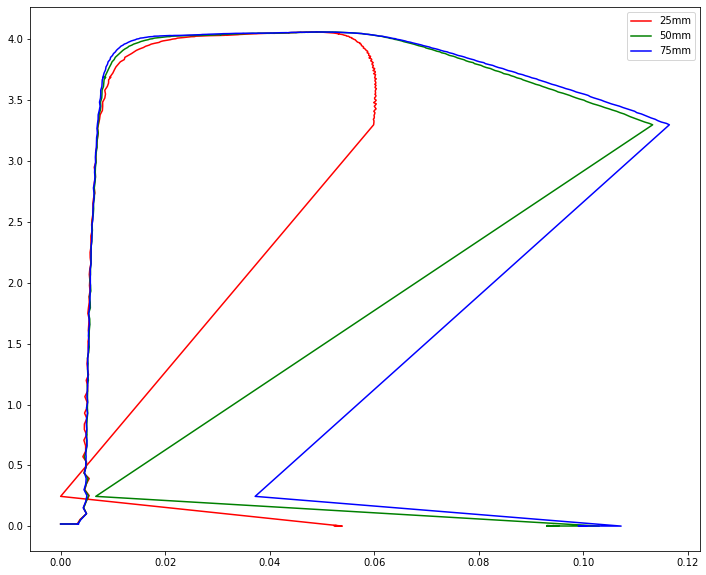

In [79]:
def cpr (sample:str,width1=25,width2=50,width3=75):

    samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
    lookup=pd.read_pickle(samplelocation,compression='zip')
    force=[lookup.loc[i,(     'add_data',             'analog_channels')][0][0] for i in lookup.index]
    positions=pd.read_excel('Y:\\Istra Repositories\\ch-gr_exports\\Querzug_overview.xlsx')
    positions=positions.iloc[:,1:].set_index('name')

    stencil1=create_full_stencil(lookup,positions,sample,width1)
    stencil2=create_full_stencil(lookup,positions,sample,width2)
    stencil3=create_full_stencil(lookup,positions,sample,width3)

    stenciled_lookup_1=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil1))
    meanvector1=[(np.mean(np.mean(stenciled_lookup_1.loc[i,('strains','strain_p1')]))) for i in stenciled_lookup_1.index]
    stenciled_lookup_2=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil2))
    meanvector2=[(np.mean(np.mean(stenciled_lookup_2.loc[i,('strains','strain_p1')]))) for i in stenciled_lookup_2.index]
    stenciled_lookup_3=lookup.loc[:,[('strains','strain_p1'),('strains','strain_p2')]].applymap(lambda x:apply_full_stencil(x,stencil3))
    meanvector3=[(np.mean(np.mean(stenciled_lookup_3.loc[i,('strains','strain_p1')]))) for i in stenciled_lookup_3.index]


    fig,ax=plt.subplots(figsize=(12,10))
    ax.plot(meanvector1,force,c='red',label='25mm')
    ax.plot(meanvector2,force,c='green',label='50mm')
    ax.plot(meanvector3,force,c='blue',label='75mm')
    plt.legend()
    plt.show()
cpr('MC_A_8xiii')

In [80]:
display(positions.head(15))

,ok,crack,pos
name,,,
MC_A_6xi,1.0,135.0,143.0
MC_A_6xiii,1.0,115.0,119.0
MC_A_6yi,2.0,114.0,117.0
MC_A_6yii,2.0,47.0,50.0
MC_A_6yiii,2.0,100.0,95.0
MC_A_8xi,3.0,143.0,NaN
MC_A_8xii,3.0,NaN,NaN
MC_A_8xiii,1.0,170.0,117.5
MC_A_8yi,2.0,107.0,110.0


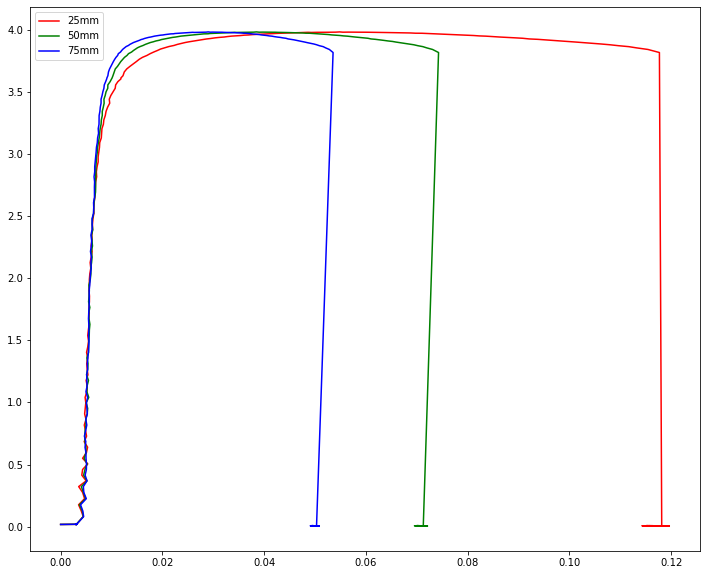

In [81]:
cpr('MC_B_8xiii')

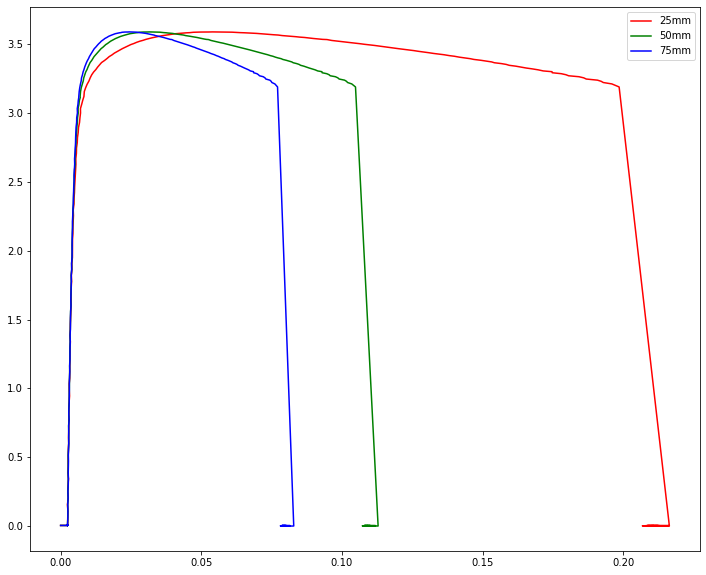

In [82]:
cpr('QL_B_8xii')